## G-1. SUMMA simulation using Output Control

## 1. Import pySUMMA 3.0.0

In [1]:
import pysumma as ps
import numpy as np
import xarray as xr

## 2. Create Simulatioin Object

In [2]:
executable = "/usr/bin/summa.exe"
file_manager = 'SummaModel_ReynoldsAspenStand_StomatalResistance/settings/summa_fileManager_riparianAspenSimpleResistance.txt'

s = ps.Simulation(executable, file_manager)

## 3. Explore Forcing file list

In [3]:
forcing = s.force_file_list.open_forcing_data()
forcing[0]

<xarray.Dataset>
Dimensions:    (hru: 1, time: 87672)
Coordinates:
  * time       (time) datetime64[ns] 1998-10-01T00:59:59.999996640 ... 2008-1...
Dimensions without coordinates: hru
Data variables:
    hruId      (hru) int32 ...
    latitude   (hru) float64 ...
    longitude  (hru) float64 ...
    data_step  timedelta64[ns] ...
    LWRadAtm   (time, hru) float64 ...
    SWRadAtm   (time, hru) float64 ...
    airpres    (time, hru) float64 ...
    airtemp    (time, hru) float64 ...
    pptrate    (time, hru) float64 ...
    spechum    (time, hru) float64 ...
    windspd    (time, hru) float64 ...
Attributes:
    dataset_orig_path:  /d2/anewman/summa/summaTestCases/testCases_data/input...
    history:            Tue Sep 27 21:53:08 2016: ncrename -d nHRU,hru ./inpu...
    NCO:                "4.6.0"

### Check Time step of forcing data: 1hr

In [4]:
forcing[0]['time'].values

array(['1998-10-01T00:59:59.999996640', '1998-10-01T02:00:00.000003360',
       '1998-10-01T03:00:00.000000000', ...,
       '2008-09-30T21:59:59.999996672', '2008-09-30T23:00:00.000003328',
       '2008-10-01T00:00:00.000000000'], dtype='datetime64[ns]')

## 4. Explore Output control text file

At a minimum, each line in the output control file will contain two fields, separated by a **`|`**. The first field will be the variable name as specified in **`build/source/dshare/var_lookup.f90`** (case-sensitive). The second field will be the frequency of the model output specified as a multiple of the time resolution in the model forcing files. Thus, if you want to output data for every forcing time step, then this value should be equal to 1. If you want daily output and your forcing frequency is 3 hours, then this value should be equal to 8. Note that you can specify different output frequencies for separate variables, but at this time you can specify only a single output frequency for each variable. For example, you can store **`scalarSenHeatTotal`** with an output frequency of 1 and **`scalarLatHeatTotal`** with an output frequency of 8, but you cannot specify two different output frequencies for **`scalarSenHeatTotal`**.

For most variables you can also output a statistical summary if you output variables at a lower frequency than your forcing frequency. To do this, you extend the number of fields you specify in the output control file, with all fields separated by a **`|`**. For the fields after the first two, you specify a series of 0's and 1's, which indicate that a specific statistic should not (0) or should be stored (1). The available statistics are (in order) the instantaneous value, the sum over the interval, the mean, the variance, the minimum, the maximum and the mode. So, a complete line in the output control file would be

```
| varName            | outFreq | inst | sum | mean | var | min | max | mode
| scalarSenHeatTotal | 24      | 0    | 1   | 1    | 0   | 1   | 1   | 0
```

In this example, the first line is a comment (starts with `!`) and then the sum, mean, min, max are calculated for **`scalarSenHeatTotal`** across 24 forcing time steps and written to the output file.

<br>

### Modifying output
And one more, we can also modify what get's written to output. 
The output control file represents the options available through columns of numeric values.
These numbers represent how to write the output. 
From the SUMMA documentation they are arranged as:

```
! varName          | outFreq | inst | sum | mean | var | min | max | mode
```

As before, let's look at what's in the `output_control` by simply printing it out.

<br>

In [5]:
print(s.output_control)

nSnow                                | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
nSoil                                | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
pptrate                              | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
airtemp                              | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarRainPlusMelt                   | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarSWE                            | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarThroughfallSnow                | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarThroughfallRain                | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarSnowSublimation                | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarInfiltration                   | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarExfiltration                   | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarSurfaceRunoff                  | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarSurfaceTemp                    | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarSenHeatTotal                   | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0
scalarLatHeatTotal                

### 4.1 Show value of  `scalarLatHeatTotal` in output control text file

* outFreq: `1` means that the output time step is the same time step with forcing data.

In [6]:
print(s.output_control['scalarLatHeatTotal'])

scalarLatHeatTotal                   | 1 | 0 | 1 | 0 | 0 | 0 | 0 | 0


### 4.2 Change value of  `scalarLatHeatTotal` in output control text file

In [7]:
# Change the output statistic from hourly instantaneous to daily total
s.output_control['scalarLatHeatTotal'] = [24, 0, 1, 0, 0, 0, 0, 0]
print(s.output_control['scalarLatHeatTotal'])

scalarLatHeatTotal                   | 24 | 0 | 1 | 0 | 0 | 0 | 0 | 0


### 4.3 Run SUMMA

In [8]:
s.run("local")

In [9]:
print(s.stdout) 

file_suffix is 'pysumma_run'.
file_master is '/home/jovyan/work/SUMMA3_Manual/SummaModel_ReynoldsAspenStand_StomatalResistance/settings/.pysumma/pysumma_run/summa_fileManager_riparianAspenSimpleResistance.txt'.
   1 controlVersion: SUMMA_FILE_MANAGER_V3.0.0
   2 simStartTime: 2006-07-01 00:00
   3 simEndTime: 2007-09-30 00:00
   4 tmZoneInfo: localTime
   5 settingsPath: /home/jovyan/work/SUMMA3_Manual/SummaModel_ReynoldsAspenStand_StomatalResistance/settings/.pysumma/pysumma_run/
   6 forcingPath: /home/jovyan/work/SUMMA3_Manual/SummaModel_ReynoldsAspenStand_StomatalResistance/data/forcingData/
   7 outputPath: /home/jovyan/work/SUMMA3_Manual/SummaModel_ReynoldsAspenStand_StomatalResistance/output/
   8 decisionsFile: summa_zDecisions_riparianAspenSimpleResistance.txt
   9 outputControlFile: meta/Model_Output.txt
  10 globalHruParamFile: summa_zLocalParamInfo.txt
  11 globalGruParamFile: summa_zBasinParamInfo.txt
  12 attributeFile: summa_zLocalAttributes_riparianAspen.nc
  13 trialPa

### 4.4 Get SUMMA output

In [10]:
s.get_output_files()

['/home/jovyan/work/SUMMA3_Manual/SummaModel_ReynoldsAspenStand_StomatalResistance/output/vegImpactsTranspire_pysumma_run_day.nc',
 '/home/jovyan/work/SUMMA3_Manual/SummaModel_ReynoldsAspenStand_StomatalResistance/output/vegImpactsTranspire_pysumma_run_timestep.nc']

In [11]:
s.output

[<xarray.Dataset>
 Dimensions:             (gru: 1, hru: 1, time: 456)
 Coordinates:
   * time                (time) datetime64[ns] 2006-07-02 ... 2007-09-30
   * hru                 (hru) int32 1
   * gru                 (gru) int32 1
 Data variables:
     scalarLatHeatTotal  (time, hru) float64 ...
     hruId               (hru) int64 ...
     gruId               (gru) int64 ...
 Attributes:
     summaVersion:     v3.0.0
     buildTime:        Wed Jul 29 15:28:12 UTC 2020
     gitBranch:        master-0-ga843a8c
     gitHash:          a843a8c46484d47979f8cb8e48b82ef71a177894
     soilStress:       NoahType
     stomResist:       Jarvis
     num_method:       itertive
     fDerivMeth:       analytic
     LAI_method:       specified
     f_Richards:       mixdform
     groundwatr:       noXplict
     hc_profile:       constant
     bcUpprTdyn:       nrg_flux
     bcLowrTdyn:       zeroFlux
     bcUpprSoiH:       liq_flux
     bcLowrSoiH:       drainage
     veg_traits:       CM_QJRMS19

### 4.5 Daily output and plotting

In [12]:
daily = s.get_output_files()[0]
xr.open_dataset(daily)

<xarray.Dataset>
Dimensions:             (gru: 1, hru: 1, time: 456)
Coordinates:
  * time                (time) datetime64[ns] 2006-07-02 ... 2007-09-30
  * hru                 (hru) int32 1
  * gru                 (gru) int32 1
Data variables:
    scalarLatHeatTotal  (time, hru) float64 ...
    hruId               (hru) int64 ...
    gruId               (gru) int64 ...
Attributes:
    summaVersion:     v3.0.0
    buildTime:        Wed Jul 29 15:28:12 UTC 2020
    gitBranch:        master-0-ga843a8c
    gitHash:          a843a8c46484d47979f8cb8e48b82ef71a177894
    soilStress:       NoahType
    stomResist:       Jarvis
    num_method:       itertive
    fDerivMeth:       analytic
    LAI_method:       specified
    f_Richards:       mixdform
    groundwatr:       noXplict
    hc_profile:       constant
    bcUpprTdyn:       nrg_flux
    bcLowrTdyn:       zeroFlux
    bcUpprSoiH:       liq_flux
    bcLowrSoiH:       drainage
    veg_traits:       CM_QJRMS1988
    canopyEmis:       difTrans
    snowIncept:       lightSnow
    windPrfile:       logBelowCanopy
    astability:       louisinv
    canopySrad:       BeersLaw
    alb_method:       varDecay
    snowLayers:       CLM_2010
    compaction:       anderson
    thCondSnow:       jrdn1991
    thCondSoil:       mixConstit
    spatial_gw:       localColumn
    subRouting:       timeDlay
    notPopulatedYet:  notPopulatedYet

In [13]:
from pysumma.plotting.plotting import Plotting

In [14]:
# create a pySUMMA plotting object using the SUMMA output NetCDF file 
P = Plotting(daily)

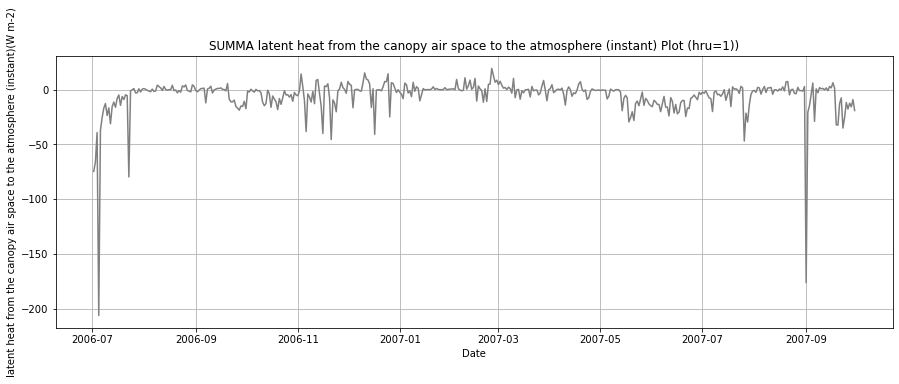

In [15]:
# timeseries plot with air pressure variable and hru 1
P.ts_plot('scalarLatHeatTotal', hru_num = 0)

### 4.6 Hourly output and plotting

In [16]:
hourly = s.get_output_files()[1]
xr.open_dataset(hourly)

<xarray.Dataset>
Dimensions:                    (gru: 1, hru: 1, ifcSoil: 9, ifcToto: 14, midSoil: 8, midToto: 13, time: 10945)
Coordinates:
  * time                       (time) datetime64[ns] 2006-07-01 ... 2007-09-30
  * hru                        (hru) int32 1
  * gru                        (gru) int32 1
Dimensions without coordinates: ifcSoil, ifcToto, midSoil, midToto
Data variables:
    pptrate                    (time, hru) float64 ...
    airtemp                    (time, hru) float64 ...
    basin__SurfaceRunoff       (time, gru) float64 ...
    basin__ColumnOutflow       (time, gru) float64 ...
    basin__AquiferStorage      (time, gru) float64 ...
    basin__AquiferRecharge     (time, gru) float64 ...
    basin__AquiferBaseflow     (time, gru) float64 ...
    basin__AquiferTranspire    (time, gru) float64 ...
    averageInstantRunoff       (time, gru) float64 ...
    averageRoutedRunoff        (time, gru) float64 ...
    nSnow                      (time, hru) int32 ...
    nSoil                      (time, hru) int32 ...
    scalarSWE                  (time, hru) float64 ...
    mLayerTemp                 (time, midToto, hru) float64 ...
    mLayerVolFracIce           (time, midToto, hru) float64 ...
    mLayerVolFracLiq           (time, midToto, hru) float64 ...
    mLayerVolFracWat           (time, midToto, hru) float64 ...
    mLayerMatricHead           (time, midSoil, hru) float64 ...
    scalarSurfaceTemp          (time, hru) float64 ...
    mLayerDepth                (time, midToto, hru) float64 ...
    iLayerHeight               (time, ifcToto, hru) float64 ...
    scalarSenHeatTotal         (time, hru) float64 ...
    scalarSnowSublimation      (time, hru) float64 ...
    scalarCanopyTranspiration  (time, hru) float64 ...
    scalarCanopyEvaporation    (time, hru) float64 ...
    scalarGroundEvaporation    (time, hru) float64 ...
    scalarThroughfallSnow      (time, hru) float64 ...
    scalarThroughfallRain      (time, hru) float64 ...
    scalarRainPlusMelt         (time, hru) float64 ...
    scalarInfiltration         (time, hru) float64 ...
    scalarExfiltration         (time, hru) float64 ...
    scalarSurfaceRunoff        (time, hru) float64 ...
    iLayerLiqFluxSoil          (time, ifcSoil, hru) float64 ...
    mLayerLiqFluxSoil          (time, midSoil, hru) float64 ...
    hruId                      (hru) int64 ...
    gruId                      (gru) int64 ...
Attributes:
    summaVersion:     v3.0.0
    buildTime:        Wed Jul 29 15:28:12 UTC 2020
    gitBranch:        master-0-ga843a8c
    gitHash:          a843a8c46484d47979f8cb8e48b82ef71a177894
    soilStress:       NoahType
    stomResist:       Jarvis
    num_method:       itertive
    fDerivMeth:       analytic
    LAI_method:       specified
    f_Richards:       mixdform
    groundwatr:       noXplict
    hc_profile:       constant
    bcUpprTdyn:       nrg_flux
    bcLowrTdyn:       zeroFlux
    bcUpprSoiH:       liq_flux
    bcLowrSoiH:       drainage
    veg_traits:       CM_QJRMS1988
    canopyEmis:       difTrans
    snowIncept:       lightSnow
    windPrfile:       logBelowCanopy
    astability:       louisinv
    canopySrad:       BeersLaw
    alb_method:       varDecay
    snowLayers:       CLM_2010
    compaction:       anderson
    thCondSnow:       jrdn1991
    thCondSoil:       mixConstit
    spatial_gw:       localColumn
    subRouting:       timeDlay
    notPopulatedYet:  notPopulatedYet

In [17]:
# create a pySUMMA plotting object using the SUMMA output NetCDF file 
P = Plotting(hourly)

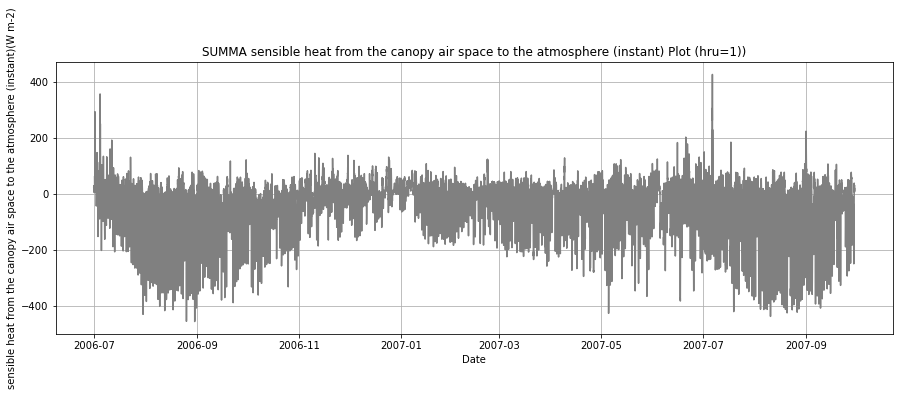

In [18]:
# timeseries plot with air pressure variable and hru 1
P.ts_plot('scalarSenHeatTotal', hru_num = 0)

### Check

meaning of `inst`, `mean`, `var`, `min`, `max`, `mode`,